In [1]:
from qcutils.credential import load_provider
from qcutils.benchmarks import QASMBenchmark
from qcutils.pulse import CircAmpTimeSeries, BasisPulse
from qcutils.pulse.amptimeseries.metric import dist, min_circ_dist_in_list

from qiskit import QuantumCircuit, transpile, schedule, Aer
from qiskit.quantum_info import Operator
from qiskit.quantum_info import state_fidelity
import qiskit.quantum_info as qi
import numpy as np
import matplotlib.pyplot as plt


provider = load_provider()
backend = provider.get_backend("ibm_lagos")

bm = QASMBenchmark(r"../../QASMBench", "small", num_qubits_list=list(range(8)), remove_final_measurements=True, do_transpile=True, backend=backend, seed_transpiler=0)

In [2]:
# save the current basis pulse library

bp = BasisPulse(backend)
bp.save_basis_amp_time_series_list(f"./data/basis_pulse_{backend.configuration().backend_name}.pickle")

In [3]:
def max_energy(circ_dict):
    max_e = 0
    for circ_name, circ in circ_dict.items():
        curr_e = np.sum(CircAmpTimeSeries.from_circ(circ, backend).total())
        if max_e < curr_e:
            max_e = curr_e
    return max_e

def min_mean_power(circ_dict):
    min_mp = np.inf
    for circ_name, circ in circ_dict.items():
        curr_mp = np.mean(CircAmpTimeSeries.from_circ(circ, backend).total())
        if min_mp > curr_mp:
            min_mp = curr_mp
    return min_mp

def max_duration(circ_dict):
    max_d = 0
    for circ_name, circ in circ_dict.items():
        curr_d = schedule(circ, backend).duration
        if max_d < curr_d:
            max_d = curr_d
    return max_d

In [4]:
def uniform_energy(circ_dict, precision = 1):
    bp = BasisPulse(backend)
    energy_dict = {}
    for qubit in range(backend.configuration().n_qubits):
        x_sched = bp.get_basis_gate_schedule("x", qubit)
        energy_dict[qubit] = 2 * np.sum(CircAmpTimeSeries.from_sched(x_sched, backend).total())
    
    def find_min_difference(numbers, target, precision = 1):
        transformed_numbers = {}
        for key, number in numbers.items():
            transformed_numbers[key] = round(number * precision)
        transformed_target = round(target * precision)

        dp = [float('inf')] * (transformed_target + 1)
        dp[0] = 0
        for i in range(1, transformed_target + 1):
            for num in transformed_numbers.values():
                if num <= i:
                    dp[i] = min(dp[i], dp[i - num] + 1)
        result = {}
        current_sum = transformed_target
        for key, value in reversed(transformed_numbers.items()):
            while current_sum >= value and dp[current_sum] == dp[current_sum - value] + 1:
                if key in result:
                    result[key] += 1
                else:
                    result[key] = 1
                current_sum -= value
        return result

    max_e = max_energy(circ_dict)
    uniformed_circ_dict = {}
    for circ_name, circ in circ_dict.items():
        circ = circ.copy()
        sched = schedule(circ, backend)
        curr_e = np.sum(CircAmpTimeSeries.from_sched(sched, backend).total())
        if curr_e < max_e:
            energy_diff = max_e - curr_e
            chosen_gates = find_min_difference(energy_dict, energy_diff, precision = precision)
            for qubit, num_gates in chosen_gates.items():
                for _ in range(num_gates):
                    circ.x(qubit)
                    circ.x(qubit)
            uniformed_circ_dict[circ_name] = circ
        else:
            uniformed_circ_dict[circ_name] = circ
    return uniformed_circ_dict


def uniform_mean_power(circ_dict):
    min_mp = min_mean_power(circ_dict)
    uniformed_circ_dict = {}

    granularity = backend.configuration().timing_constraints['granularity']
    for circ_name, circ in circ_dict.items():
        circ = circ.copy()
        sched = schedule(circ, backend)
        energy = np.sum(CircAmpTimeSeries.from_sched(sched, backend).total())
        curr_mp = energy / sched.duration
        if curr_mp > min_mp:
            duration = energy / min_mp
            for ch in sched.channels:
                if sched.ch_duration(ch) == sched.duration:
                    if ch.prefix == 'd':
                        circ.delay(round(int(duration - sched.duration) / granularity) * granularity, ch.index)
                        uniformed_circ_dict[circ_name] = circ
        else:
            uniformed_circ_dict[circ_name] = circ
    return uniformed_circ_dict


def uniform_duration(circ_dict):
    max_d = max_duration(circ_dict)
    uniformed_circ_dict = {}
    for circ_name, circ in circ_dict.items():
        circ = circ.copy()
        sched = schedule(circ, backend)
        curr_d = sched.duration
        if curr_d < max_d:
            for ch in sched.channels:
                if sched.ch_duration(ch) == curr_d:
                    if ch.prefix == 'd':
                        circ.delay(max_d - curr_d, ch.index)
                        uniformed_circ_dict[circ_name] = circ
        else:
            uniformed_circ_dict[circ_name] = circ
    return uniformed_circ_dict

In [5]:
circ_dict = {}
power_time_series_dict = {}
for circ_name, circ in bm.items():
    try:
        power_time_series_dict[circ_name] = CircAmpTimeSeries.from_circ(circ, backend).total()
        circ_dict[circ_name] = circ
    except:
        continue

energy_dict = {circ_name: np.sum(power_timeseries) for circ_name, power_timeseries in power_time_series_dict.items()}
mean_power_dict = {circ_name: np.mean(power_timeseries) for circ_name, power_timeseries in power_time_series_dict.items()}
duration_dict = {circ_name: len(power_timeseries) for circ_name, power_timeseries in power_time_series_dict.items()}

defensed_energy_dict = {circ_name: np.sum(CircAmpTimeSeries.from_circ(circ, backend).total()) for circ_name, circ in uniform_energy(circ_dict, precision=100).items()}
defensed_mean_power_dict = {circ_name: np.mean(CircAmpTimeSeries.from_circ(circ, backend).total()) for circ_name, circ in uniform_mean_power(circ_dict).items()}
defensed_duration_dict = {circ_name: len(CircAmpTimeSeries.from_circ(circ, backend).total()) for circ_name, circ in uniform_duration(circ_dict).items()}

In [6]:
def plot_bm_info(data_type, filepath = None):
    if data_type == "Energy":
        data = energy_dict
        defensed_data = defensed_energy_dict
    elif data_type == "Mean Power":
        data = mean_power_dict
        defensed_data = defensed_mean_power_dict
    elif data_type == "Duration":
        data = duration_dict
        defensed_data = defensed_duration_dict

    # import pandas as pd
    # df = pd.DataFrame([data, defensed_data], index=['Original', 'Defensed']).transpose()

    # fig, ax= plt.subplots(1,1, figsize=(6,5))

    # df.plot.bar(ax=ax)
    # ax.set_xlabel('YEAR')

    # fig.tight_layout()

    
    plt.figure(figsize=(5, 3))
    sx = np.arange(len(data.keys()))
    displacement = 0.2
    plt.bar(data.keys(), data.values(), width=-0.2, align='edge', label='Original')
    plt.bar(defensed_data.keys(), defensed_data.values(), width=0.2, align='edge', label='Defensed')
    plt.ylabel(data_type)
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()

    if filepath:
        plt.savefig(filepath)

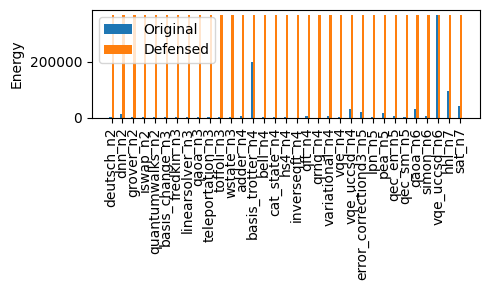

In [7]:
# plot_bm_info("Energy", filepath=r"E:\Research\quantum-computing-power-side-channel-attacks\paper\figure\bm_energy.pdf")
plot_bm_info("Energy")

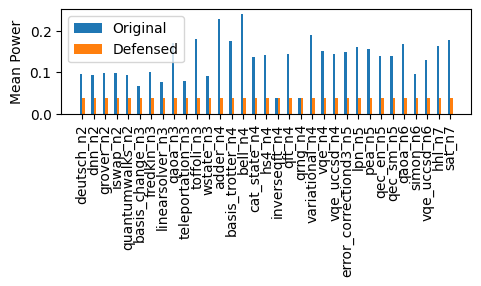

In [9]:
plot_bm_info("Mean Power")

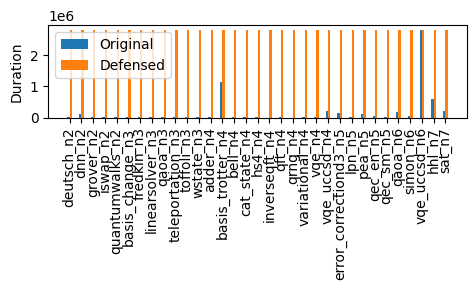

In [10]:
plot_bm_info("Duration")